In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from utils import *

import numpy as np
import cvxopt

cvxopt.solvers.options['show_progress'] = False

%matplotlib inline

In [2]:
"""
Get the preprocessed data:
X and y are dicts, has keys train, val and test. keys gives you what word (or pair of words) each dimension corresponds to.

You can also get bigram features if you call preprocess(bigram = True)`
Another optional argument mincount specifies the frequency cutoff for inclusion of a word/bigram in the
dictionary.

"""

X, y, keys = preprocess()

Feature size:  1464


In [3]:
class Kernel(object):
    """
    A class containing all kinds of kernels.
    Note: the kernel should work for both input (Matrix, vector) and (vector, vector)
    """
    @staticmethod
    def linear():
        def f(x, y):
            return np.dot(x, y)
        return f

    @staticmethod
    def gaussian(gamma):  # we use the commonly used name, although it's not really a Gaussian
        def f(x, y):
            exponent = - gamma * np.linalg.norm((x-y).transpose(), 2, 0) ** 2
            return np.exp(exponent)
        return f

    @staticmethod
    def _poly(dimension, offset):
        def f(x, y):
            return (offset + np.dot(x, y)) ** dimension
        return f

    @staticmethod
    def inhomogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=1.0)

    @staticmethod
    def homogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=0.0)

    @staticmethod
    def hyperbolic_tangent(kappa, c):
        def f(x, y):
            return np.tanh(kappa * np.dot(x, y) + c)
        return f

In [4]:
class SVM(object):
    def __init__(self, kernel, c):
        """
        Build a SVM given kernel function and C

        Parameters
        ----------
        kernel : function
            a function takes input (Matrix, vector) or (vector, vector)
        c : a scalar
            balance term

        Returns
        -------
        """
        self._kernel = kernel
        self._c = c

    def fit(self, X, y):
        """
        Fit the model given data X and ground truth label y

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        -------
        """
        # Solve the QP problem to get the multipliers
        lagrange_multipliers = self._compute_multipliers(X, y)
        # Get all the support vectors, support weights and bias
        self._construct_predictor(X, y, lagrange_multipliers)
    
    def predict(self, X):
        """
        Predict the label given data X

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        y : 1D array
            predicted label
        """
        result = np.full(X.shape[0], self._bias) # allocate
        
#         YOUR CODE HERE
        for ind in range(X.shape[0]):
            K = self._kernel(self._support_vectors, X[ind])
            result[ind] = np.sum(np.multiply(self._weights, np.multiply(self._support_vector_labels, K))) + self._bias
        return np.sign(result)

    def _kernel_matrix(self, X):
        """
        Get the kernel matrix.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        K : 2D array
            N x N kernel matrix
        """
        N, d = X.shape
        K = np.zeros((N, N))
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
        return K

    def _construct_predictor(self, X, y, lagrange_multipliers):
        """
        Given the data, label and the multipliers, extract the support vectors and calculate the bias

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label
        lagrange_multipliers: 1D array
            the solution of lagrange_multiplier

        Fills in relevant variables: model bias and weights (alphas), and details of support vectors
        
        -------
        """
        support_vector_indices = \
            lagrange_multipliers > 1e-5
            
        print("SV number: ", np.sum(support_vector_indices))

        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]

        """
        Get the bias term (w_0)
        """
#         YOUR CODE HERE
        # alpha<C and y = +1 or -1
#         indm = []
#         indp = []
        K = self._kernel_matrix(X)
#         for index in support_vector_indices:
#             if y[index] == 1 and support_multipliers[index] < self._c - 1e-5:
#                 indp.append(index)
#             if y[index] == 0 and support_multipliers[index] < self._c - 1e-5:
#                 indm.append(index)
#         print("indm:", indm)
#         print("indp:", indp)

        support_kernels = K.T[support_vector_indices]
        sv_number = np.sum(support_vector_indices)
        N = y.shape
#         km = np.zeros(N)
#         kp = np.zeros(N)
#         nkm = 0
#         nkp = 0
#         for ind in range(sv_number):
#             if support_multipliers[ind] < self._c - 1e-5 and y[ind] == 1:
#                 nkp = nkp + 1.0
#                 kp = (kp + support_kernels[ind])/nkp
#             if support_multipliers[ind] < self._c - 1e-5 and y[ind] == -1:
#                 nkm = nkm + 1.0
#                 km = (km + support_kernels[ind])/nkm      
#         bm = np.sum(np.multiply(lagrange_multipliers, np.multiply(y, km)))
#         bp = np.sum(np.multiply(lagrange_multipliers, np.multiply(y, kp)))
#         bias = -(bm + bp)/2.0
        omega0 = []
        for ind in range(sv_number):
            if support_multipliers[ind] < self._c - 1e-5:
                omega0.append(1.0/y[ind] - np.sum(np.multiply(lagrange_multipliers, np.multiply(y, support_kernels[ind]))))
        bias = np.mean(omega0)
        print("bias mean/std:{}/{}".format(bias, np.std(omega0)))
    
        self._bias=bias
        self._weights=support_multipliers
        self._support_vectors=support_vectors
        self._support_vector_labels=support_vector_labels

    def _compute_multipliers(self, X, y):
        """
        Given the data, label, solve the QP program to get lagrange multiplier.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        lagrange_multipliers: 1D array
        -------
        """
        N, d = X.shape

        K = self._kernel_matrix(X)
        """
        The standard QP solver formulation:
        min 1/2 x^T H x + f^T x
        s.t.
        Ax <=  a
        Bx = b
        """
        H = np.dot(np.dot(np.diag(y), K),np.diag(y))
        H = cvxopt.matrix(H)
        f = -np.ones([N])
        f = cvxopt.matrix(f)

        A = np.concatenate((np.eye(N), -np.eye(N)), axis = 0)
        a = np.concatenate((self._c * np.ones(N), np.zeros(N)))
        A = cvxopt.matrix(A)
        a = cvxopt.matrix(a)
        
        

        B = y
        b = np.zeros([1])
        B = cvxopt.matrix(B).T
        b = cvxopt.matrix(b)
#         print(B.size)
        
        # call the QP solver
        solution = cvxopt.solvers.qp(H, f, A, a, B, b)

        # Lagrange multipliers (the unknown vector 'x' is our alphas)
        return np.ravel(solution['x'])

Test the trainer.
The following code would generate data which the grounth truth split is x+y = 0.5.

SV number:  7
bias mean/std:-4.94462219174/9.22599419739e-09


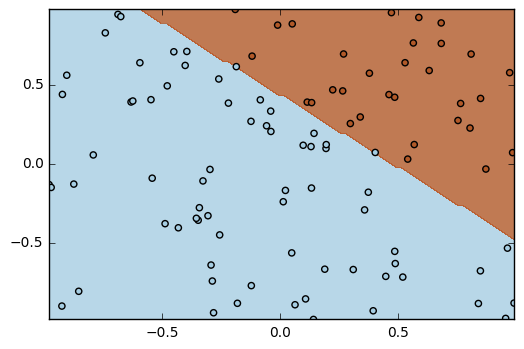

In [5]:
clf = SVM(Kernel.linear(), 100)
test_linear_SVM(clf, 100)

SV number:  12
bias mean/std:6.80989713461/1.98761598089


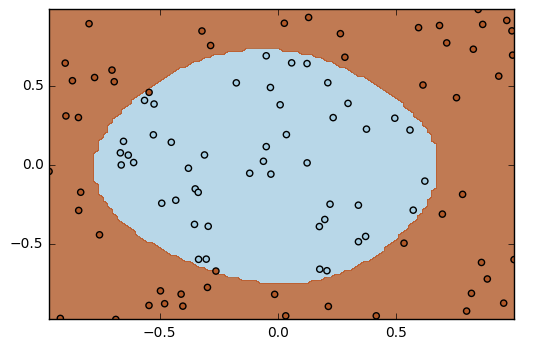

In [6]:
clf = SVM(Kernel.gaussian(1), 100)
test_rbf_SVM(clf, 100)

If you think your code is correct, then we can move to the real problem. Below are some code examples; you will need to fill in some details, and extend these to any experiments you want to run.

In [7]:
c_range = [i/10.0 for i in range(1, 11)] 
c_max = 0
acc_max = -10
for C in c_range:
    clf = SVM(Kernel.linear(), C)
    clf.fit(X['train'], y['train'].astype('double'))
    print("C = ", C)
    y_hat = clf.predict(X['train'])
    print("Acc on train: ", np.mean(y_hat == y['train']))
    y_hat = clf.predict(X['val'])
    print("Acc on val: ", np.mean(y_hat == y['val']))
    acc = np.mean(y_hat == y['val'])
    if acc > acc_max:
        c_max = C
        acc_max = acc

SV number:  1641
bias mean/std:0.358954629591/1.37166381726
C =  0.1
Acc on train:  0.892252252252
Acc on val:  0.73
SV number:  1532
bias mean/std:0.41561878796/1.35381640396
C =  0.2
Acc on train:  0.918558558559
Acc on val:  0.734
SV number:  1460
bias mean/std:0.476124894552/1.32703839573
C =  0.3
Acc on train:  0.929369369369
Acc on val:  0.724
SV number:  1400
bias mean/std:0.595369025716/1.37382550789
C =  0.4
Acc on train:  0.931531531532
Acc on val:  0.728
SV number:  1366
bias mean/std:0.672586050233/1.40097699145
C =  0.5
Acc on train:  0.938378378378
Acc on val:  0.732
SV number:  1333
bias mean/std:0.666741271841/1.36982946422
C =  0.6
Acc on train:  0.943063063063
Acc on val:  0.728
SV number:  1316
bias mean/std:0.747781982658/1.38202965241
C =  0.7
Acc on train:  0.945585585586
Acc on val:  0.726
SV number:  1301
bias mean/std:0.761806349733/1.41706068535
C =  0.8
Acc on train:  0.94990990991
Acc on val:  0.722
SV number:  1279
bias mean/std:0.771199937577/1.37506007051

Choose the best C, and predict the label for test data.

In [8]:
C = c_max
clf = SVM(Kernel.linear(), C)
clf.fit(X['train'], y['train'].astype('double'))
y_hat = clf.predict(X['test'])
save_submission('sub_linear.csv', y_hat)


SV number:  1532
bias mean/std:0.41561878796/1.35381640396


RBF (Gaussian) kernel SVM

In [13]:
c_range = [1.0] 
gamma_range = [0.01, 0.05]
gamma_range = gamma_range + [i/10.0 for i in range(1, 10)]
c_max = 0
gamma_max = 0
acc_max = -10
for C in c_range:
    for gamma in gamma_range:
        clf = SVM(Kernel.gaussian(gamma), C)
        clf.fit(X['train'], y['train'].astype('double'))
        print("C = ", C)
        print("gamma = ", gamma)
        y_hat = clf.predict(X['train'])
        print("Acc on train: ", np.mean(y_hat == y['train']))
        y_hat = clf.predict(X['val'])
        print("Acc on val: ", np.mean(y_hat == y['val']))
        acc = np.mean(y_hat == y['val'])
        if acc > acc_max:
            gamma_max = gamma
            c_max = C
            acc_max = acc
        

SV number:  2064
bias mean/std:-1.84072471768/1.20750043086
C =  1.0
gamma =  0.01
Acc on train:  0.831711711712
Acc on val:  0.712
SV number:  2114
bias mean/std:-0.227589412332/1.27259239477
C =  1.0
gamma =  0.05
Acc on train:  0.937297297297
Acc on val:  0.742
SV number:  2348
bias mean/std:-0.100502273259/1.32818836487
C =  1.0
gamma =  0.1
Acc on train:  0.983063063063
Acc on val:  0.74
SV number:  2615
bias mean/std:-0.292491699319/1.15163218432
C =  1.0
gamma =  0.2
Acc on train:  0.994954954955
Acc on val:  0.552
SV number:  2711
bias mean/std:-0.363841953872/1.01912670283
C =  1.0
gamma =  0.3
Acc on train:  0.998918918919
Acc on val:  0.42
SV number:  2743
bias mean/std:-0.37239270274/0.977556807877
C =  1.0
gamma =  0.4
Acc on train:  0.99963963964
Acc on val:  0.386
SV number:  2756
bias mean/std:-0.345207236247/0.961032533621
C =  1.0
gamma =  0.5
Acc on train:  1.0
Acc on val:  0.368
SV number:  2767
bias mean/std:-0.276806685449/0.947055555782
C =  1.0
gamma =  0.6
Acc 

In [10]:
clf = SVM(Kernel.gaussian(gamma_max), c_max)
clf.fit(X['train'], y['train'].astype('double'))
y_hat = clf.predict(X['test'])
save_submission('sub_rbf.csv', y_hat)


SV number:  2354
bias mean/std:0.270462699401/0.959597593352
